In [4]:
%pip install PyPDF2 spacy nltk wordcloud matplotlib seaborn plotly

Note: you may need to restart the kernel to use updated packages.


# Análise de Artigos Científicos

In [5]:
import os
import PyPDF2
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import spacy
import subprocess
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Modelo 'en_core_web_sm' não encontrado. Baixando agora...")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

PASTA_PDFS = "artigos"

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavognz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Funções Comuns

In [6]:
def extrair_texto_pdf_limpo(path):
    doc = PyPDF2.PdfReader(open(path, "rb"))
    total_paginas = len(doc.pages)

    linhas_por_pagina = []
    for pagina in doc.pages:
        texto = pagina.extract_text() or ""
        linhas = [l.strip() for l in texto.splitlines() if l.strip()]
        linhas_por_pagina.append(linhas)

    contador_linhas = defaultdict(int)
    for linhas in linhas_por_pagina:
        linhas_unicas = set(linhas)
        for linha in linhas_unicas:
            contador_linhas[linha] += 1

    limiar = 0.8 * total_paginas  # descarta linhas que aparecem em 80%+ das páginas

    texto_limpo = ""
    for linhas in linhas_por_pagina:
        linhas_filtradas = [l for l in linhas if contador_linhas[l] < limiar]
        texto_limpo += " ".join(linhas_filtradas) + " "

    return texto_limpo

In [7]:
class Artigo:
    def __init__(self, nome, caminho):
        self.nome = nome
        self.caminho = caminho
        self.unigramas = Counter()
        self.referencias = ""
        self.ano = None
        self.objetivo = ""
        self.problema = ""
        self.metodo = ""
        self.contribuicao = ""
        self.trabalhos_futuros = []
        self.tecnicas_mencionadas = Counter()
    
    def adicionar_unigramas(self, tokens):
        """Adiciona tokens e atualiza o contador de unigramas"""
        self.unigramas.update(tokens)
    
    def definir_referencias(self, referencias):
        """Define as referências do artigo"""
        self.referencias = referencias
    
    def definir_ano(self, ano):
        """Define o ano do artigo"""
        self.ano = ano
    
    def definir_informacoes(self, objetivo, problema, metodo, contribuicao):
        """Define as informações extraídas do artigo"""
        self.objetivo = objetivo
        self.problema = problema
        self.metodo = metodo
        self.contribuicao = contribuicao
    
    def definir_trabalhos_futuros(self, trabalhos_futuros):
        """Define os trabalhos futuros identificados"""
        self.trabalhos_futuros = trabalhos_futuros
    
    def definir_tecnicas_mencionadas(self, tecnicas):
        """Define as técnicas mencionadas no artigo"""
        self.tecnicas_mencionadas = tecnicas
    
    def obter_top_unigramas(self, n=10):
        """Retorna os top N unigramas do artigo"""
        return self.unigramas.most_common(n)
    
    def __str__(self):
        return f"Artigo: {self.nome} (Ano: {self.ano})"

In [8]:
def preprocessar_texto(texto):
    doc = nlp(texto.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]
    return tokens

In [9]:
def remover_referencias(texto):
    partes = re.split(r"\breferences\b", texto, flags=re.IGNORECASE)
    return partes[0], partes[1] if len(partes) > 1 else ""

In [10]:
def extrair_ano_metadata(path_pdf):
    import PyPDF2
    import re
    try:
        with open(path_pdf, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            info = reader.metadata
            data_criacao = info.get('/CreationDate', '')
            match = re.search(r'D:(\d{4})', data_criacao)
            if match:
                return int(match.group(1))
    except Exception as e:
        print(f"Erro ao extrair metadados de {path_pdf}: {e}")
    return None


In [11]:
def extrair_trabalhos_futuros(texto):
    """Extrai seções relacionadas a trabalhos futuros"""
    # Padrões para identificar trabalhos futuros
    padroes_futuro = [
        r"\bfuture\s+work\b",
        r"\bfuture\s+research\b",
        r"\bfuture\s+directions\b",
        r"\bfuture\s+studies\b",
        r"\bnext\s+step\b",
        r"\bfurther\s+research\b",
        r"\bfurther\s+work\b",
        r"\bfurther\s+studies\b",
        r"\bfurther\s+investigation\b",
        r"\bin\s+future\b",
        r"\bwill\s+be\s+explored\b",
        r"\bwill\s+be\s+investigated\b",
        r"\bwill\s+be\s+studied\b",
        r"\bplanned\s+for\s+future\b",
        r"\bfuture\s+plans\b"
    ]
    
    doc = nlp(texto)
    trabalhos_futuros = []
    
    for sentenca in doc.sents:
        for padrao in padroes_futuro:
            if re.search(padrao, sentenca.text, re.IGNORECASE):
                trabalhos_futuros.append(sentenca.text.strip())
                break
    
    return trabalhos_futuros

def extrair_tecnicas_mencionadas(texto):
    """Extrai técnicas específicas mencionadas nos artigos"""
    # Lista de técnicas comuns em IoT/Security/AI
    tecnicas_conhecidas = [
        "machine learning", "deep learning", "neural network", "artificial intelligence",
        "blockchain", "encryption", "cryptography", "authentication", "authorization",
        "firewall", "intrusion detection", "vulnerability assessment", "penetration testing",
        "edge computing", "cloud computing", "fog computing", "distributed computing",
        "big data", "data mining", "data analysis", "statistical analysis",
        "survey", "interview", "case study", "experiment", "simulation",
        "clustering", "classification", "regression", "reinforcement learning",
        "natural language processing", "computer vision", "image processing",
        "iot", "internet of things", "sensor networks", "wireless networks",
        "protocol", "algorithm", "framework", "model", "architecture",
        "api", "rest", "http", "mqtt", "coap", "websocket",
        "database", "sql", "nosql", "mongodb", "mysql", "postgresql"
    ]
    
    texto_lower = texto.lower()
    tecnicas_encontradas = Counter()
    
    for tecnica in tecnicas_conhecidas:
        count = len(re.findall(r'\b' + re.escape(tecnica) + r'\b', texto_lower))
        if count > 0:
            tecnicas_encontradas[tecnica] = count
    
    return tecnicas_encontradas

### Etapa 1: Leitura, pré-processamento e top 10 unigramas

In [12]:
artigos = []

for arquivo in os.listdir(PASTA_PDFS):
    if not arquivo.endswith(".pdf"):
        continue
    caminho = os.path.join(PASTA_PDFS, arquivo)
    print(f"Lendo {arquivo}...")
    
    # Criar objeto Artigo
    artigo = Artigo(arquivo, caminho)
    
    # Extrair texto e processar
    texto = extrair_texto_pdf_limpo(caminho)
    corpo, ref = remover_referencias(texto)
    
    # Adicionar referências
    artigo.definir_referencias(ref)
    
    # Processar tokens e adicionar unigramas
    tokens = preprocessar_texto(corpo)
    artigo.adicionar_unigramas(tokens)
    
    # Extrair trabalhos futuros
    trabalhos_futuros = extrair_trabalhos_futuros(corpo)
    artigo.definir_trabalhos_futuros(trabalhos_futuros)
    
    # Extrair técnicas mencionadas
    tecnicas = extrair_tecnicas_mencionadas(corpo)
    artigo.definir_tecnicas_mencionadas(tecnicas)
    
    # Extrair ano
    ano = extrair_ano_metadata(caminho)
    if ano:
        artigo.definir_ano(ano)
    
    artigos.append(artigo)

# Consolidar todos os unigramas para estatísticas gerais
todos_unigramas = Counter()
for artigo in artigos:
    todos_unigramas.update(artigo.unigramas)

print("\nTop 10 Unigramas (Global):")
for palavra, freq in todos_unigramas.most_common(10):
    print(f"{palavra}: {freq}")

print("\n\nTop 5 Unigramas por Artigo:")
for artigo in artigos:
    print(f"\n{artigo.nome}:")
    for palavra, freq in artigo.obter_top_unigramas(5):
        print(f"  {palavra}: {freq}")

# print("\n\nReferências encontradas:\n")

# for i, artigo in enumerate(artigos, 1):
#     print(f"Referência {i} - {artigo.nome}:\n\n")
#     print(artigo.referencias.strip() + "\n\n")
#     print("-" * 40 + "\n\n")

Lendo A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf...
Lendo Towards an integrated privacy protection framework for IoT Contextualising regulatory requirements with industry best practices.pdf...
Lendo Emerging privacy challenges and approaches in CAV systems.pdf...
Lendo Automation_in_Agriculture_and_IoT.pdf...
Lendo Cloud for IoT - A survey of technologies and security features of public cloud IoT solutions.pdf...
Lendo Secure - zero touch device onboarding.pdf...
Lendo Towards an understanding of emerging cyber security threats in mapping the IoT.pdf...
Lendo Developing_complex_services_in_an_IoT_ecosystem.pdf...
Lendo IoT_Challenges_and_Issues_in_Indian_Perspective.pdf...
Lendo Next_Generation_Lightweight_Cryptography_for_Smart_IoT_Devices__Implementation_Challenges_and_Applications.pdf...

Top 10 Unigramas (Global):
iot: 350
privacy: 248
datum: 237
device: 219
service: 216
use: 173
security: 159
system: 157
risk: 129
attack: 12

### Etapa 2: Extrair objetivo, problema, método e contribuição

In [13]:
padroes = {
    "objetivo": re.compile(r"\b(we|objective|aim|purpose|goal)(s)? (propose(s)?|present(s)?|of|this|the)? (study|article|research|paper)?\b", re.IGNORECASE),
    "problema": re.compile(r"\b(problem|issue|challenge)(s)?\b", re.IGNORECASE),
    "metodo": re.compile(r"\b(method|methodology|interview(s)?|survey(s)?|content analysis|case study|experiment|approach|technique(s)?|) (were|was)? (conducted|used|realized|taken)?\b", re.IGNORECASE),
    "contribuicao": re.compile(r"\b(we|our|this|the)? (study|article|research|paper)? (contribute(s)?|contribution(s)?|add(s)?|)\b", re.IGNORECASE),
}

# Atualizar os objetos Artigo existentes com informações extraídas
for artigo in artigos:
    print(f"Extraindo infos de {artigo.nome}...")

    texto = extrair_texto_pdf_limpo(artigo.caminho)
    corpo, _ = remover_referencias(texto)

    doc = nlp(corpo) # Processamento com spaCy

    objetivo = ""
    problema = ""
    metodo = ""
    contribuicao = ""

    # Verifica padrões em cada sentença
    for sentenca in doc.sents:
        if padroes["objetivo"].search(sentenca.text):
            objetivo += sentenca.text.strip() + ";;\n"
        if padroes["problema"].search(sentenca.text):
            problema += sentenca.text.strip() + ";;\n"
        if padroes["metodo"].search(sentenca.text):
            metodo += sentenca.text.strip() + ";;\n"
        if padroes["contribuicao"].search(sentenca.text):
            contribuicao += sentenca.text.strip() + ";;\n"

    # Definir informações no objeto Artigo
    artigo.definir_informacoes(objetivo, problema, metodo, contribuicao)

print("\n\nResultados extraídos:\n")
for artigo in artigos:
    print(f"Arquivo: {artigo.nome}\n")
    print("Objetivo:\n")
    print(f"{artigo.objetivo}\n\n")
    print("Problema:\n")
    print(f"{artigo.problema}\n\n")
    print("Método:\n")
    print(f"{artigo.metodo}\n\n")
    print("Contribuição:\n")
    print(f"{artigo.contribuicao}\n\n")
    print("-" * 40 + "\n\n")


Extraindo infos de A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf...
Extraindo infos de Towards an integrated privacy protection framework for IoT Contextualising regulatory requirements with industry best practices.pdf...
Extraindo infos de Emerging privacy challenges and approaches in CAV systems.pdf...
Extraindo infos de Automation_in_Agriculture_and_IoT.pdf...
Extraindo infos de Cloud for IoT - A survey of technologies and security features of public cloud IoT solutions.pdf...
Extraindo infos de Secure - zero touch device onboarding.pdf...
Extraindo infos de Towards an understanding of emerging cyber security threats in mapping the IoT.pdf...
Extraindo infos de Developing_complex_services_in_an_IoT_ecosystem.pdf...
Extraindo infos de IoT_Challenges_and_Issues_in_Indian_Perspective.pdf...
Extraindo infos de Next_Generation_Lightweight_Cryptography_for_Smart_IoT_Devices__Implementation_Challenges_and_Applications.pdf...


Resultado

### Etapa 3: Salvar dados extraídos

In [14]:
def etapa3_salvar_dados(artigos):
    with open("dados_extraidos.txt", "w", encoding="utf-8") as f:
        # Cabeçalho
        f.write("ANÁLISE DE ARTIGOS CIENTÍFICOS\n")
        f.write("="*50 + "\n\n")
        
        # Resumo geral
        f.write("RESUMO GERAL:\n")
        f.write(f"Total de artigos: {len(artigos)}\n")
        artigos_com_ano = [a for a in artigos if a.ano]
        if artigos_com_ano:
            anos = [a.ano for a in artigos_com_ano]
            f.write(f"Período: {min(anos)} - {max(anos)}\n")
        f.write("\n" + "-"*50 + "\n\n")
        
        # Dados por artigo
        for artigo in artigos:
            f.write(f"ARTIGO: {artigo.nome}\n")
            f.write(f"Ano: {artigo.ano}\n")
            f.write("\nObjetivo:\n")
            f.write(f"{artigo.objetivo}\n")
            f.write("\nProblema:\n")
            f.write(f"{artigo.problema}\n")
            f.write("\nMétodo:\n")
            f.write(f"{artigo.metodo}\n")
            f.write("\nContribuição:\n")
            f.write(f"{artigo.contribuicao}\n")
            
            f.write("\nTop 10 Unigramas:\n")
            for palavra, freq in artigo.obter_top_unigramas(10):
                f.write(f"  {palavra}: {freq}\n")
            
            if artigo.tecnicas_mencionadas:
                f.write("\nTécnicas Mencionadas:\n")
                for tecnica, freq in artigo.tecnicas_mencionadas.most_common(5):
                    f.write(f"  {tecnica}: {freq}\n")
            
            if artigo.trabalhos_futuros:
                f.write("\nTrabalhos Futuros:\n")
                for i, trabalho in enumerate(artigo.trabalhos_futuros, 1):
                    f.write(f"  {i}. {trabalho}\n")
            
            f.write("\nReferências:\n")
            f.write(f"{artigo.referencias}\n")
            f.write("\n" + "="*50 + "\n\n")



In [15]:
def analisar_artigos_por_ano(artigos):
    """Analisa distribuição dos artigos por ano"""
    anos = [artigo.ano for artigo in artigos if artigo.ano]
    contador_anos = Counter(anos)
    print("Distribuição por ano:")
    for ano, count in sorted(contador_anos.items()):
        print(f"  {ano}: {count} artigos")
    return contador_anos

def obter_unigramas_comuns_entre_artigos(artigos, min_artigos=2):
    """Encontra unigramas que aparecem em pelo menos min_artigos artigos"""
    unigrama_artigos = defaultdict(set)
    
    for i, artigo in enumerate(artigos):
        for unigrama in artigo.unigramas:
            unigrama_artigos[unigrama].add(i)
    
    unigramas_comuns = {}
    for unigrama, artigos_ids in unigrama_artigos.items():
        if len(artigos_ids) >= min_artigos:
            freq_total = sum(artigos[i].unigramas[unigrama] for i in artigos_ids)
            unigramas_comuns[unigrama] = {
                'frequencia_total': freq_total,
                'num_artigos': len(artigos_ids),
                'artigos': [artigos[i].nome for i in artigos_ids]
            }
    
    return unigramas_comuns

def buscar_artigos_por_termo(artigos, termo):
    """Busca artigos que contêm um termo específico"""
    artigos_encontrados = []
    for artigo in artigos:
        if termo.lower() in artigo.unigramas:
            freq = artigo.unigramas[termo.lower()]
            artigos_encontrados.append((artigo, freq))
    
    # Ordenar por frequência
    artigos_encontrados.sort(key=lambda x: x[1], reverse=True)
    return artigos_encontrados

### Execução Principal

In [16]:
# Execução das etapas já foi feita nas células anteriores
# Os objetos 'artigos' já contêm todas as informações necessárias

# Salvar dados extraídos
etapa3_salvar_dados(artigos)

# Análises adicionais
print("\n" + "="*50)
print("ANÁLISES ADICIONAIS")
print("="*50)

# Análise por ano
analisar_artigos_por_ano(artigos)

# Unigramas comuns
print("\nUnigramas que aparecem em pelo menos 3 artigos:")
unigramas_comuns = obter_unigramas_comuns_entre_artigos(artigos, min_artigos=3)
for unigrama, info in sorted(unigramas_comuns.items(), key=lambda x: x[1]['frequencia_total'], reverse=True)[:10]:
    print(f"  {unigrama}: {info['frequencia_total']} ocorrências em {info['num_artigos']} artigos")

# Exemplo de busca por termo
print("\nBuscar artigos que contêm 'security':")
artigos_security = buscar_artigos_por_termo(artigos, "security")
for artigo, freq in artigos_security[:5]:
    print(f"  {artigo.nome}: {freq} ocorrências")

print("\nProcessamento concluído. Dados extraídos salvos em dados_extraidos.txt")


ANÁLISES ADICIONAIS
Distribuição por ano:
  2015: 1 artigos
  2018: 1 artigos
  2019: 8 artigos

Unigramas que aparecem em pelo menos 3 artigos:
  iot: 350 ocorrências em 9 artigos
  privacy: 248 ocorrências em 7 artigos
  datum: 237 ocorrências em 10 artigos
  device: 219 ocorrências em 10 artigos
  service: 216 ocorrências em 10 artigos
  use: 173 ocorrências em 10 artigos
  security: 159 ocorrências em 8 artigos
  system: 157 ocorrências em 9 artigos
  risk: 129 ocorrências em 7 artigos
  attack: 121 ocorrências em 6 artigos

Buscar artigos que contêm 'security':
  A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf: 55 ocorrências
  Next_Generation_Lightweight_Cryptography_for_Smart_IoT_Devices__Implementation_Challenges_and_Applications.pdf: 25 ocorrências
  Cloud for IoT - A survey of technologies and security features of public cloud IoT solutions.pdf: 19 ocorrências
  Towards an understanding of emerging cyber security threats in

### Exemplos de uso da nova estrutura

Agora você pode acessar facilmente as informações de cada artigo:

In [17]:
# Exemplo 1: Acessar informações de um artigo específico
if artigos:
    primeiro_artigo = artigos[0]
    print(f"Nome: {primeiro_artigo.nome}")
    print(f"Ano: {primeiro_artigo.ano}")
    print(f"Top 5 unigramas: {primeiro_artigo.obter_top_unigramas(5)}")
    print(f"Tem referências: {'Sim' if primeiro_artigo.referencias else 'Não'}")

# Exemplo 2: Filtrar artigos por ano
artigos_2020_plus = [artigo for artigo in artigos if artigo.ano and artigo.ano >= 2020]
print(f"\nArtigos de 2020 em diante: {len(artigos_2020_plus)}")

# Exemplo 3: Encontrar artigo com mais unigramas
artigo_mais_tokens = max(artigos, key=lambda a: sum(a.unigramas.values()))
print(f"\nArtigo com mais tokens: {artigo_mais_tokens.nome} ({sum(artigo_mais_tokens.unigramas.values())} tokens)")

# Exemplo 4: Comparar unigramas entre dois artigos
if len(artigos) >= 2:
    artigo1, artigo2 = artigos[0], artigos[1]
    unigramas_comuns = set(artigo1.unigramas.keys()) & set(artigo2.unigramas.keys())
    print(f"\nUnigramas comuns entre {artigo1.nome} e {artigo2.nome}: {len(unigramas_comuns)}")
    if unigramas_comuns:
        print(f"Exemplos: {list(unigramas_comuns)[:5]}")

Nome: A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf
Ano: 2019
Top 5 unigramas: [('attack', 103), ('risk', 99), ('cav', 75), ('system', 58), ('security', 55)]
Tem referências: Sim

Artigos de 2020 em diante: 0

Artigo com mais tokens: A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf (3365 tokens)

Unigramas comuns entre A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf e Towards an integrated privacy protection framework for IoT Contextualising regulatory requirements with industry best practices.pdf: 268
Exemplos: ['detail', 'propose', 'potential', 'apply', 'address']


## Análises Solicitadas

### 1. Nuvem de Palavras Geral

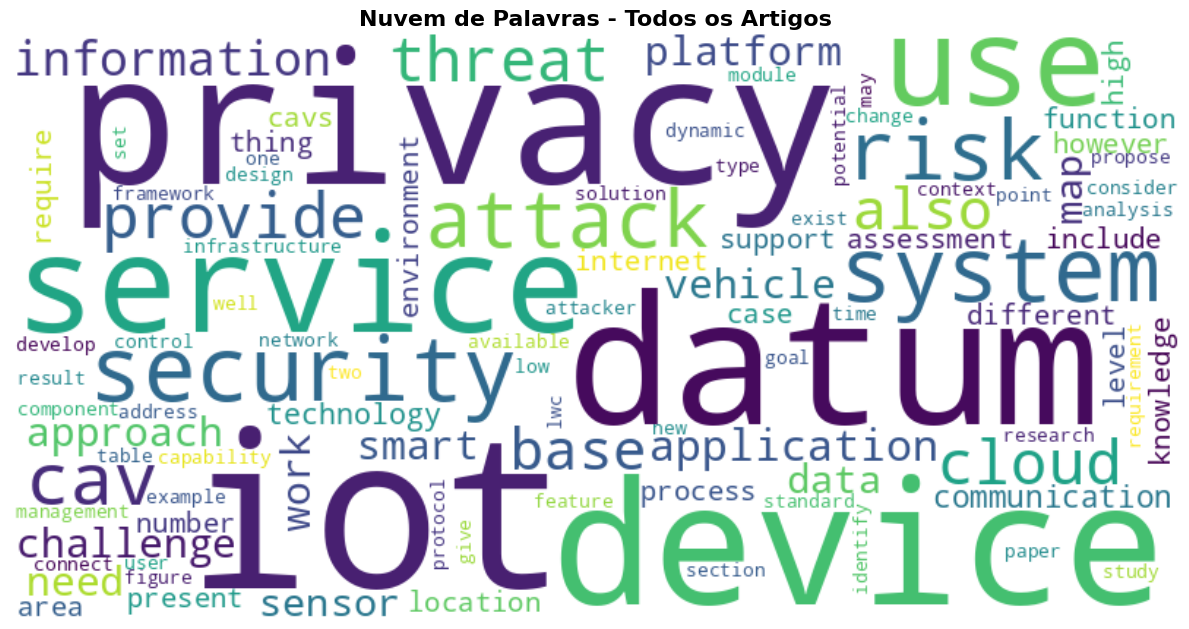


Top 20 palavras mais citadas:
 1. iot: 350
 2. privacy: 248
 3. datum: 237
 4. device: 219
 5. service: 216
 6. use: 173
 7. security: 159
 8. system: 157
 9. risk: 129
10. attack: 121
11. cav: 105
12. provide: 103
13. cloud: 100
14. threat: 98
15. also: 91
16. base: 88
17. information: 81
18. application: 80
19. challenge: 77
20. approach: 75


In [18]:
# Configurar matplotlib para trabalhar corretamente
plt.rcParams['figure.figsize'] = (12, 8)

# Criar nuvem de palavras geral
def criar_nuvem_palavras_geral(artigos):
    # Consolidar todos os unigramas
    todos_unigramas = Counter()
    for artigo in artigos:
        todos_unigramas.update(artigo.unigramas)
    
    # Filtrar palavras muito comuns e muito raras
    palavras_filtradas = {palavra: freq for palavra, freq in todos_unigramas.items() 
                         if freq >= 3 and len(palavra) > 2}  # Pelo menos 3 ocorrências e mais de 2 caracteres
    
    if not palavras_filtradas:
        print("Nenhuma palavra encontrada para a nuvem de palavras.")
        return
    
    # Criar a nuvem de palavras
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(palavras_filtradas)
    
    # Plotar
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras - Todos os Artigos', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar top 20 palavras
    print("\nTop 20 palavras mais citadas:")
    for i, (palavra, freq) in enumerate(todos_unigramas.most_common(20), 1):
        print(f"{i:2d}. {palavra}: {freq}")

criar_nuvem_palavras_geral(artigos)

### 2. Técnicas Mais Mencionadas nos Artigos

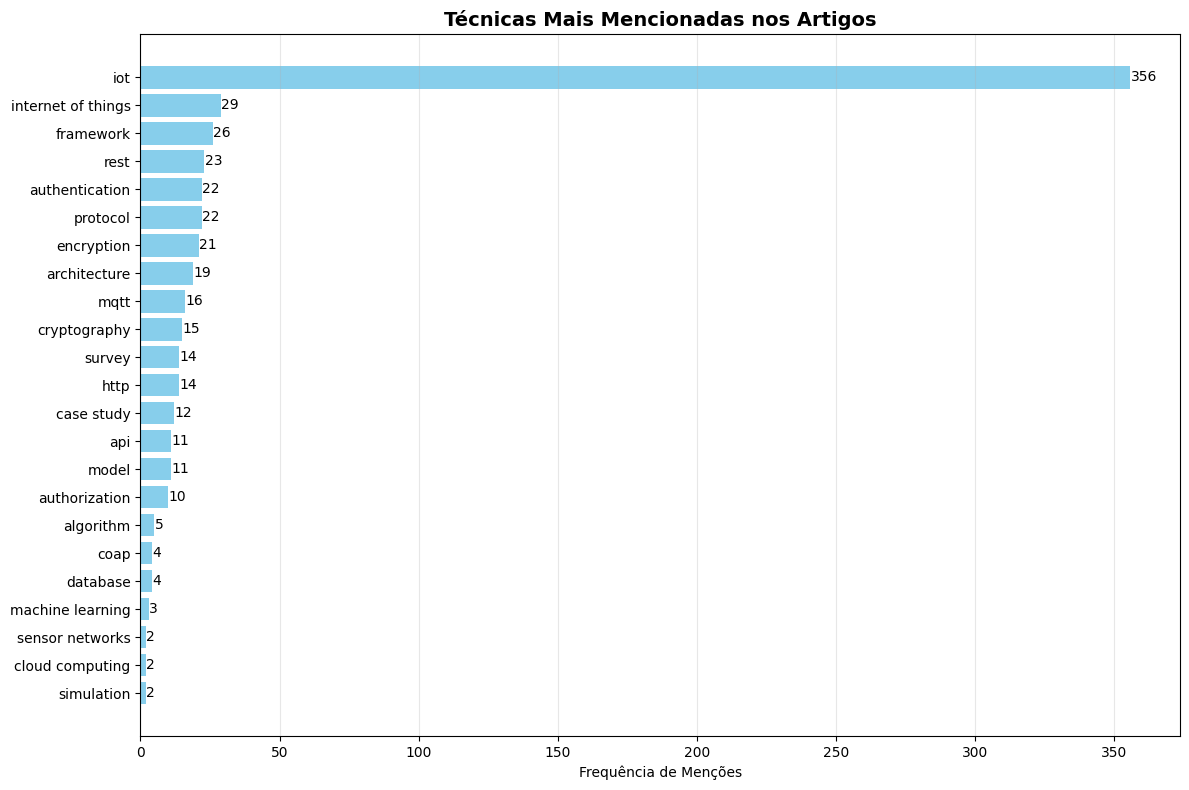


Detalhamento das técnicas por artigo:

A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf:
  architecture: 11
  case study: 6
  framework: 2
  model: 2
  simulation: 1

Towards an integrated privacy protection framework for IoT Contextualising regulatory requirements with industry best practices.pdf:
  iot: 64
  framework: 20
  blockchain: 1
  internet of things: 1
  model: 1

Emerging privacy challenges and approaches in CAV systems.pdf:
  cryptography: 3
  authentication: 3
  internet of things: 3
  protocol: 3
  iot: 2

Automation_in_Agriculture_and_IoT.pdf:
  iot: 8
  internet of things: 2
  machine learning: 1
  survey: 1
  image processing: 1

Cloud for IoT - A survey of technologies and security features of public cloud IoT solutions.pdf:
  iot: 86
  rest: 18
  authentication: 17
  mqtt: 16
  encryption: 15

Secure - zero touch device onboarding.pdf:
  iot: 30
  protocol: 3
  architecture: 2
  internet of things: 1
  coap: 1

Tow

In [19]:
def analisar_tecnicas_mencionadas(artigos):
    # Consolidar todas as técnicas mencionadas
    todas_tecnicas = Counter()
    for artigo in artigos:
        todas_tecnicas.update(artigo.tecnicas_mencionadas)
    
    # Filtrar técnicas com pelo menos 2 menções
    tecnicas_relevantes = {tecnica: freq for tecnica, freq in todas_tecnicas.items() if freq >= 2}
    
    if not tecnicas_relevantes:
        print("Nenhuma técnica encontrada com frequência suficiente.")
        return
    
    # Criar DataFrame para visualização
    df_tecnicas = pd.DataFrame(list(tecnicas_relevantes.items()), columns=['Técnica', 'Frequência'])
    df_tecnicas = df_tecnicas.sort_values('Frequência', ascending=True)
    
    # Gráfico de barras horizontais
    plt.figure(figsize=(12, 8))
    bars = plt.barh(df_tecnicas['Técnica'], df_tecnicas['Frequência'], color='skyblue')
    plt.xlabel('Frequência de Menções')
    plt.title('Técnicas Mais Mencionadas nos Artigos', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                str(int(bar.get_width())), ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar detalhes por artigo
    print("\nDetalhamento das técnicas por artigo:")
    for artigo in artigos:
        if artigo.tecnicas_mencionadas:
            print(f"\n{artigo.nome}:")
            for tecnica, freq in artigo.tecnicas_mencionadas.most_common(5):
                print(f"  {tecnica}: {freq}")

analisar_tecnicas_mencionadas(artigos)

### 3. Evolução Temporal dos Termos Utilizados

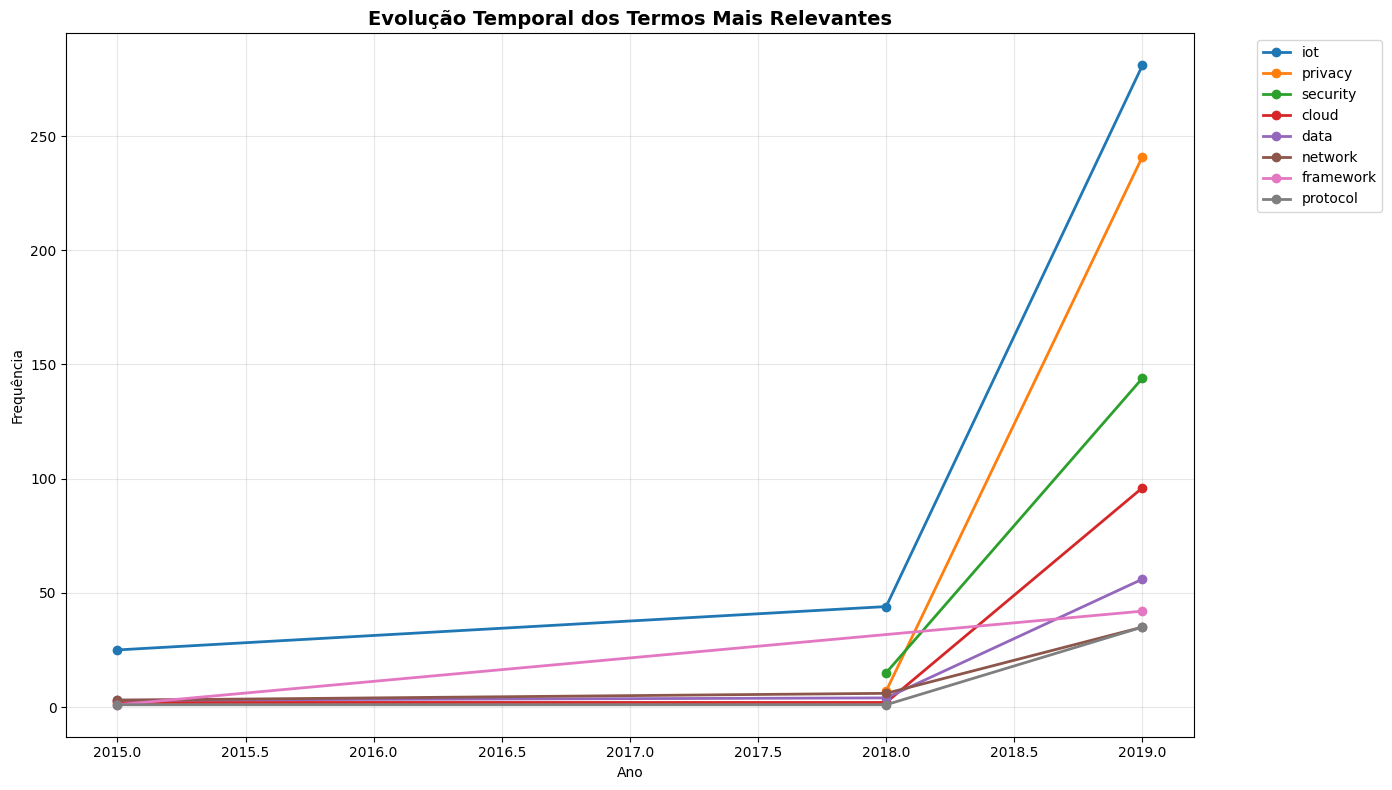


Estatísticas por ano:

2015 (1 artigos):
  service: 114
  use: 33
  platform: 33
  ontology: 28
  room: 27

2018 (1 artigos):
  iot: 44
  india: 19
  challenge: 17
  security: 15
  technology: 14

2019 (8 artigos):
  iot: 281
  privacy: 241
  datum: 214
  device: 196
  security: 144


In [20]:
def analisar_evolucao_temporal(artigos):
    # Filtrar artigos que têm ano definido
    artigos_com_ano = [artigo for artigo in artigos if artigo.ano]
    
    if not artigos_com_ano:
        print("Nenhum artigo com ano definido encontrado.")
        return
    
    # Agrupar artigos por ano
    artigos_por_ano = defaultdict(list)
    for artigo in artigos_com_ano:
        artigos_por_ano[artigo.ano].append(artigo)
    
    # Calcular termos mais frequentes por ano
    termos_por_ano = {}
    for ano, artigos_do_ano in artigos_por_ano.items():
        termos_ano = Counter()
        for artigo in artigos_do_ano:
            termos_ano.update(artigo.unigramas)
        termos_por_ano[ano] = termos_ano
    
    # Selecionar termos interessantes para acompanhar
    termos_interesse = ['security', 'privacy', 'iot', 'blockchain', 'machine', 'learning', 
                       'artificial', 'intelligence', 'cloud', 'edge', 'data', 'network',
                       'authentication', 'encryption', 'protocol', 'algorithm', 'framework']
    
    # Criar DataFrame para visualização
    dados_evolucao = []
    anos_ordenados = sorted(termos_por_ano.keys())
    
    for termo in termos_interesse:
        for ano in anos_ordenados:
            freq = termos_por_ano[ano].get(termo, 0)
            if freq > 0:  # Só incluir se o termo aparecer
                dados_evolucao.append({
                    'Ano': ano,
                    'Termo': termo,
                    'Frequência': freq
                })
    
    if not dados_evolucao:
        print("Nenhum termo de interesse encontrado nos artigos.")
        return
    
    df_evolucao = pd.DataFrame(dados_evolucao)
    
    # Gráfico de linha mostrando evolução temporal
    plt.figure(figsize=(14, 8))
    
    # Selecionar apenas os termos mais frequentes para visualização
    termos_mais_frequentes = df_evolucao.groupby('Termo')['Frequência'].sum().nlargest(8).index
    df_filtrado = df_evolucao[df_evolucao['Termo'].isin(termos_mais_frequentes)]
    
    for termo in termos_mais_frequentes:
        dados_termo = df_filtrado[df_filtrado['Termo'] == termo]
        plt.plot(dados_termo['Ano'], dados_termo['Frequência'], 
                marker='o', label=termo, linewidth=2)
    
    plt.xlabel('Ano')
    plt.ylabel('Frequência')
    plt.title('Evolução Temporal dos Termos Mais Relevantes', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Mostrar estatísticas por ano
    print("\nEstatísticas por ano:")
    for ano in anos_ordenados:
        num_artigos = len(artigos_por_ano[ano])
        top_termos = termos_por_ano[ano].most_common(5)
        print(f"\n{ano} ({num_artigos} artigos):")
        for termo, freq in top_termos:
            print(f"  {termo}: {freq}")

analisar_evolucao_temporal(artigos)

### 4. Termos que Aparecem como Trabalhos Futuros

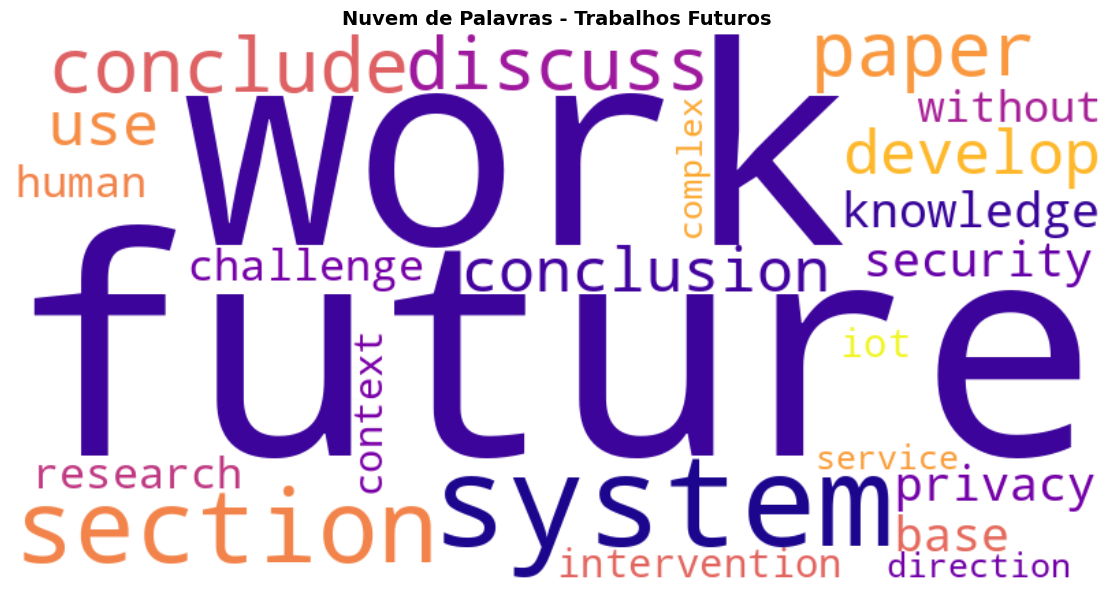

Top 15 termos mais mencionados em trabalhos futuros:
 1. future: 11
 2. work: 11
 3. system: 4
 4. section: 3
 5. conclude: 2
 6. paper: 2
 7. discuss: 2
 8. conclusion: 2
 9. develop: 2
10. use: 2
11. knowledge: 2
12. base: 2
13. security: 2
14. privacy: 2
15. challenge: 2


Trabalhos futuros identificados em 8 artigos:

A simplified approach for dynamic security risk management in connected and autonomous vehicles.pdf (2019):
----------------------------------------
1. Section 6 concludes the paper and discusses the future work.
2. 6. Conclusion and Future Work
3. We anticipate that some of our future  work will be  to develop more uses of the knowledge-based  system on the security analysis, and to extend this res earch in simulation environment for further ve...

Towards an integrated privacy protection framework for IoT Contextualising regulatory requirements with industry best practices.pdf (2019):
----------------------------------------
1. Section 6 concludes and delineates fut

In [21]:
def analisar_trabalhos_futuros(artigos):
    # Coletar todos os trabalhos futuros
    todos_trabalhos_futuros = []
    artigos_com_futuros = []
    
    for artigo in artigos:
        if artigo.trabalhos_futuros:
            todos_trabalhos_futuros.extend(artigo.trabalhos_futuros)
            artigos_com_futuros.append(artigo)
    
    if not todos_trabalhos_futuros:
        print("Nenhum trabalho futuro identificado nos artigos.")
        return
    
    # Processar texto dos trabalhos futuros para extrair termos
    texto_futuros = " ".join(todos_trabalhos_futuros)
    tokens_futuros = preprocessar_texto(texto_futuros)
    termos_futuros = Counter(tokens_futuros)
    
    # Filtrar termos relevantes (mais de 1 ocorrência e mais de 2 caracteres)
    termos_relevantes = {termo: freq for termo, freq in termos_futuros.items() 
                        if freq > 1 and len(termo) > 2}
    
    if termos_relevantes:
        # Criar nuvem de palavras para trabalhos futuros
        wordcloud_futuros = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            max_words=50,
            colormap='plasma',
            relative_scaling=0.5,
            random_state=42
        ).generate_from_frequencies(termos_relevantes)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_futuros, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nuvem de Palavras - Trabalhos Futuros', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Top termos em trabalhos futuros
        print("Top 15 termos mais mencionados em trabalhos futuros:")
        for i, (termo, freq) in enumerate(termos_futuros.most_common(15), 1):
            print(f"{i:2d}. {termo}: {freq}")
    
    # Mostrar trabalhos futuros por artigo
    print(f"\n\nTrabalhos futuros identificados em {len(artigos_com_futuros)} artigos:")
    print("=" * 60)
    
    for artigo in artigos_com_futuros:
        print(f"\n{artigo.nome} ({artigo.ano}):")
        print("-" * 40)
        for i, trabalho in enumerate(artigo.trabalhos_futuros, 1):
            # Limitar o tamanho para melhor visualização
            trabalho_resumido = trabalho[:200] + "..." if len(trabalho) > 200 else trabalho
            print(f"{i}. {trabalho_resumido}")
    
    # Análise quantitativa
    print(f"\n\nResumo quantitativo:")
    print(f"Total de sentenças sobre trabalhos futuros: {len(todos_trabalhos_futuros)}")
    print(f"Artigos com trabalhos futuros identificados: {len(artigos_com_futuros)}")
    print(f"Termos únicos em trabalhos futuros: {len(termos_futuros)}")

analisar_trabalhos_futuros(artigos)